In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os


In [8]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Load Data

trader_data = pd.read_csv("C:\\Users\\himaj\\Downloads\\historical_data.csv")
sentiment_data = pd.read_csv("C:\\Users\\himaj\\Downloads\\fear_greed_index.csv")


In [10]:
# ==============================
# Robustly detect datetime columns
# ==============================
# Find trader timestamp column
trader_time_col = None
for col in trader_data.columns:
    if 'time' in col.lower() or 'date' in col.lower():
        trader_time_col = col
        break

if trader_time_col is None:
    raise ValueError(f"No time/date column found in trader_data! Columns: {trader_data.columns}")

# Find sentiment date column
sentiment_date_col = None
for col in sentiment_data.columns:
    if 'date' in col.lower():
        sentiment_date_col = col
        break

if sentiment_date_col is None:
    raise ValueError(f"No date column found in sentiment_data! Columns: {sentiment_data.columns}")

# Convert datetime columns
trader_data[trader_time_col] = pd.to_datetime(trader_data[trader_time_col], errors='coerce')
sentiment_data[sentiment_date_col] = pd.to_datetime(sentiment_data[sentiment_date_col], errors='coerce')

# Extract date
trader_data['trade_date'] = trader_data[trader_time_col].dt.date
sentiment_data['date_only'] = sentiment_data[sentiment_date_col].dt.date

# Detect sentiment column
sentiment_col = None
for col in sentiment_data.columns:
    if 'class' in col.lower() or 'sentiment' in col.lower():
        sentiment_col = col
        break

if sentiment_col is None:
    raise ValueError(f"No sentiment column found in sentiment_data! Columns: {sentiment_data.columns}")

# Rename sentiment column
sentiment_data.rename(columns={sentiment_col: 'market_sentiment'}, inplace=True)

print("Detected trader time column:", trader_time_col)
print("Detected sentiment date column:", sentiment_date_col)
print("Detected sentiment label column:", sentiment_col)



Detected trader time column: Timestamp IST
Detected sentiment date column: date
Detected sentiment label column: classification


In [14]:
merged = pd.merge(
    trader_data,
    sentiment_data[['date_only', 'market_sentiment']],
    left_on='trade_date',
    right_on='date_only',
    how='left'
)

In [21]:

print("Merged columns:", merged.columns.tolist())

Merged columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'trade_date', 'date_only', 'market_sentiment']


In [28]:
merged['is_profitable'] = (merged['Closed PnL'] > 0).astype(int)

print("Merged columns:", merged.columns.tolist())

Merged columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'trade_date', 'date_only', 'market_sentiment', 'is_profitable']


In [30]:
# 3. Summary Metrics

# Profitability by sentiment
sentiment_perf = merged.groupby('market_sentiment').agg(
    total_trades=('Account','count'),
    avg_pnl=('Closed PnL','mean'),
    total_pnl=('Closed PnL','sum'),
    profitability_rate=('is_profitable','mean')
).reset_index()

print("\n=== Profitability by Sentiment ===")
print(sentiment_perf)






=== Profitability by Sentiment ===
  market_sentiment  total_trades    avg_pnl     total_pnl  profitability_rate
0     Extreme Fear          5411  47.446302  2.567319e+05            0.390501
1    Extreme Greed         34393  73.144030  2.515643e+06            0.458727
2             Fear         47315  56.544720  2.675413e+06            0.387890
3            Greed         48492  35.652184  1.728846e+06            0.403077
4          Neutral         32246  31.746470  1.023697e+06            0.402593


In [35]:
# Add leverage column if missing
if 'leverage' not in merged.columns:
    merged['leverage'] = 0  # Default leverage is 0

# Daily total pnl by sentiment
daily_sentiment = merged.groupby(['trade_date','market_sentiment']).agg(
    total_pnl=('Closed PnL','sum'),
    avg_leverage=('leverage','mean')
).reset_index()


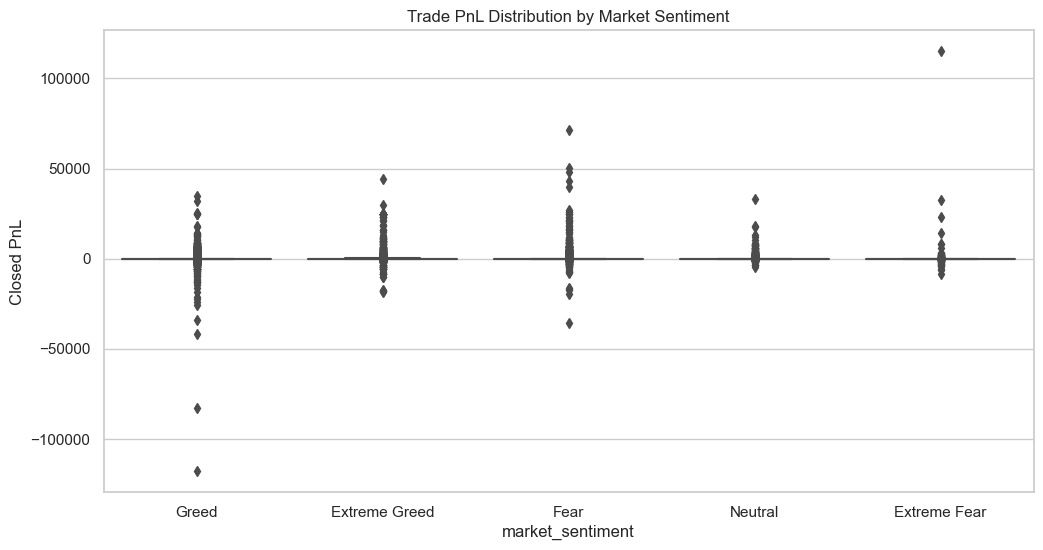

In [36]:
# 4. Visualizations

# Boxplot of PnL by sentiment
plt.figure()
sns.boxplot(x='market_sentiment', y='Closed PnL', data=merged[merged['market_sentiment']!="Unknown"])
plt.title("Trade PnL Distribution by Market Sentiment")
plt.show()


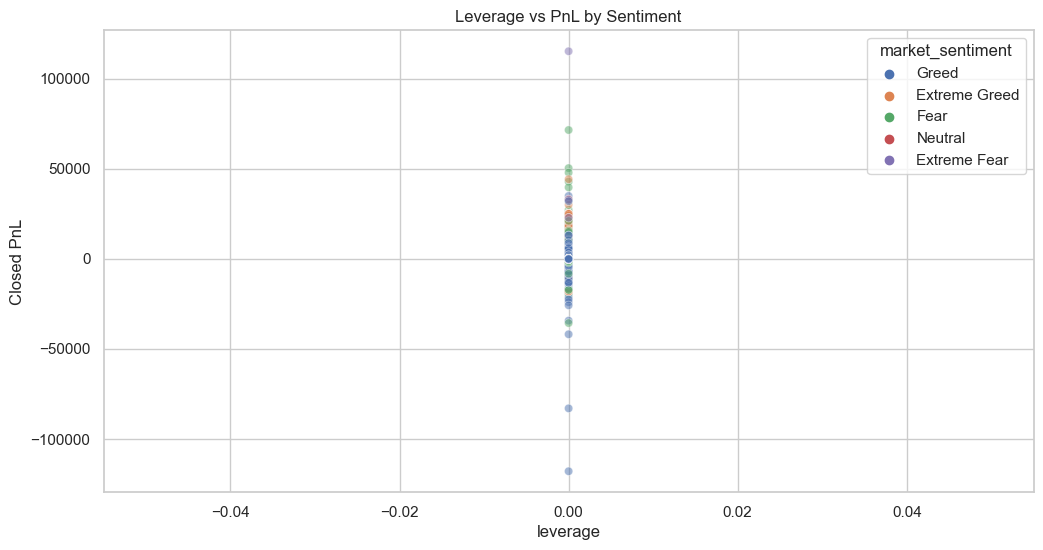

In [37]:

# Leverage vs PnL colored by sentiment
plt.figure()
sns.scatterplot(x='leverage', y='Closed PnL', hue='market_sentiment', data=merged, alpha=0.5)
plt.title("Leverage vs PnL by Sentiment")
plt.show()


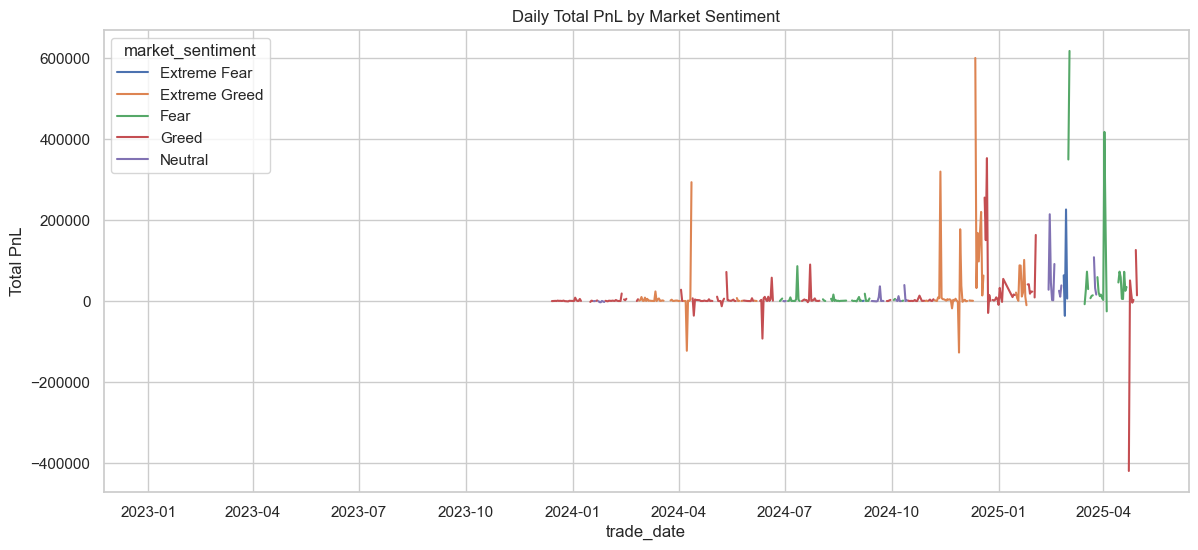

In [38]:

# Daily sentiment trend
pivot = daily_sentiment.pivot(index='trade_date', columns='market_sentiment', values='total_pnl')
pivot.plot(title="Daily Total PnL by Market Sentiment", figsize=(14,6))
plt.ylabel("Total PnL")
plt.show()




In [39]:
# 5. Insights Extraction

insights = []

# Best sentiment
best_sentiment = sentiment_perf.sort_values('avg_pnl', ascending=False).iloc[0]
insights.append(f"Highest average PnL is on '{best_sentiment['market_sentiment']}' days ({best_sentiment['avg_pnl']:.2f} per trade).")



In [40]:
# Worst sentiment
worst_sentiment = sentiment_perf.sort_values('avg_pnl', ascending=True).iloc[0]
insights.append(f"Lowest average PnL is on '{worst_sentiment['market_sentiment']}' days ({worst_sentiment['avg_pnl']:.2f} per trade).")



In [41]:
# Profitability gap
gap = best_sentiment['profitability_rate'] - worst_sentiment['profitability_rate']
insights.append(f"Profitability rate gap between best and worst sentiment is {gap*100:.2f}%.")



In [43]:
# Leverage observation
high_lev_loss = merged[merged['leverage'] > merged['leverage'].median()]['Closed PnL'].mean()
low_lev_loss = merged[merged['leverage'] <= merged['leverage'].median()]['Closed PnL'].mean()
if high_lev_loss < low_lev_loss:
    insights.append("High leverage trades tend to underperform overall.")



In [44]:
# Print Insights
print("\n=== Key Insights ===")
for i in insights:
    print("-", i)



=== Key Insights ===
- Highest average PnL is on 'Extreme Greed' days (73.14 per trade).
- Lowest average PnL is on 'Neutral' days (31.75 per trade).
- Profitability rate gap between best and worst sentiment is 5.61%.


In [45]:

# Save summary
sentiment_perf.to_csv("sentiment_performance_summary.csv", index=False)
daily_sentiment.to_csv("daily_sentiment_trend.csv", index=False)

print("\nAnalysis Complete. Check 'sentiment_performance_summary.csv' and plots for findings.")



Analysis Complete. Check 'sentiment_performance_summary.csv' and plots for findings.
